In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 4
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory='chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory='chest_xray/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory='chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
datagen = ImageDataGenerator(
    samplewise_center=True,  # center the image pixels to a mean zero
    samplewise_std_normalization=True,  # standardize the image pixels to a standard deviation of one
    rotation_range=15,  # rotate the image by 15 degrees
    width_shift_range=0.2,  # shift the image horizontally by 20%
    height_shift_range=0.2,  # shift the image vertically by 20%
    shear_range=0.2,  # shear the image by 20%
    zoom_range=0.2,  # zoom the image by 20%
    fill_mode="nearest",  # fill the gaps with the nearest pixel value
    cval=0.0,  # fill the gaps with a value of 0
    rescale=1./255  # rescale the image by 1/255 (normalization)
)

# Define directories
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Create the training generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # resize images to 128x128
    batch_size=32,
    class_mode='binary',  # or 'categorical' if you have multiple classes
    shuffle=True,
    seed=42
)

# Create the validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),  # resize images to 128x128
    batch_size=9,
    class_mode='binary',  # or 'categorical' if you have multiple classes
    shuffle=False,
    seed=42
)

# Create the test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  # resize images to 128x128
    batch_size=32,
    class_mode='binary',  # or 'categorical' if you have multiple classes
    shuffle=False,
    seed=42
)

# Visualize the augmented images
pdata_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


NameError: name 'data_iterator' is not defined

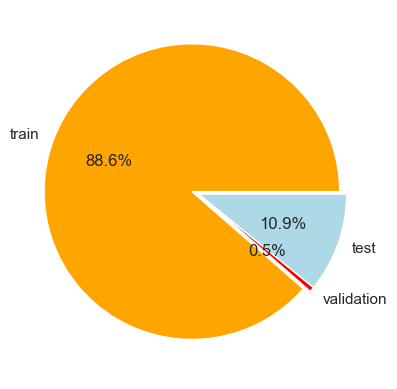

In [ ]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [ ]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [ ]:
# Extracting Features and Labels
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [ ]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val':", y_val.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [ ]:
#CNN Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the input dimensions
img_height, img_width = 224, 224

# Define the training and validation directories
train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val'

# Define the number of classes
num_classes = 2

# Define the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
CNN_model = model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8150 - loss: 0.5610 - val_accuracy: 0.8750 - val_loss: 0.2713
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2713
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9609 - loss: 0.1098 - val_accuracy: 0.8125 - val_loss: 0.4389
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.4389
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9735 - loss: 0.0813 - val_accuracy: 0.7500 - val_loss: 0.5607
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5607
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9834 - loss: 0.0528 - val_accuracy: 0.9375 - val_loss: 0

In [ ]:
#pre-train VGG16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add a new input layer to the model
input_layer = Input(shape=(224, 224, 3))
x = base_model(input_layer)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(2, activation='softmax')(x)

# Create the final model
VGG_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    'chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9767 - loss: 0.0557 - val_accuracy: 0.9375 - val_loss: 0.1801
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9910 - loss: 0.0249 - val_accuracy: 0.9375 - val_loss: 0.1474
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 993ms/step - accuracy: 0.9936 - loss: 0.0155 - val_accuracy: 0.9375 - val_loss: 0.2005
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 989ms/step - accuracy: 0.9922 - loss: 0.0176 - val_accuracy: 0.9375 - val_loss: 0.1655
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 996ms/step - accuracy: 0.9964 - loss: 0.0077 - val_accuracy: 0.8125 - val_loss: 0.8124
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 993ms/step - accuracy: 0.9937 - loss: 0.0173 - val_accuracy: 0.9375 - val_loss: 0.0953
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2499s 15s/step - accuracy: 0.9893 - loss: 0.0241 - val_accuracy: 0.8125 - val_loss: 1.1572
E